#### 공사비 1차 전처리

##### 레코드 제거
* 계약전력: 100 이상
* 접수종류명: 신설(상용/임시) 이외
* 총공사비: 60,000,000이상(11개 레코드로 예외처리)
* 공사형태명: '외선소요' 이외(나머지는 140개 정도로 예외처리)

##### 컬럼 제거
* 컬럼값이 1개로 구성된 컬럼은 학습에 영향이 없기 때문에 제거

In [1]:
import re
import sys
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings

sys.path.append('..')
from utils.data_manager import read_data, write_data

# 한글처리 지원
plt_settings()

#### 원본 데이터 불러오기

In [2]:
try:
    _start = datetime.now()
    df_data = read_data('2nd provide cons')
    print(
        f'Total Elapsed Time for Data Load: {datetime.now()-_start}\n'
        f'Shape: {df_data.shape}'
    )
except KeyError as ke:
    print(f'KeyError: {ke}')

Total Elapsed Time for Data Load: 0:00:18.814461
Shape: (19052, 143)


#### 데이터 전처리

##### 결측치 처리

In [3]:
df_data.isna().sum().sort_values(ascending=False)[:5]

신기술공종규격코드    19052
전선변압기코드번호    19052
CUD상태코드      19052
공사번호             0
더블블레이드수익금        0
dtype: int64

In [4]:
# '신기술공종규격코드', '전선변압기코드번호', '상태코드' 3컬럼이 모두 결측치이기 때문에,
# 단일값인 0으로 치환 후 이후 단일값으로 구성된 컬럼 삭제시 제거
df_data.fillna(0, inplace=True)

##### 학습대상 레코드 추출

In [5]:
training_data_conditions = \
    (df_data['접수종류명'] == '신설(상용/임시)') & \
    (df_data['계약전력'] < 100) & \
    (df_data['공사형태코드'] == 2) & \
    (df_data['총공사비'] < 60000000)
    
# 학습대상 이외의 데이터 건수 확인
df_data[~training_data_conditions].shape

(3158, 143)

In [6]:
# 전체 레코드(19,052)중에 3,158건으로 예외로 제거
# (제거 후 인덱스를 갱신함)
df_data = df_data[training_data_conditions].reset_index(drop=True)

##### 1개의 값으로 구성된 컬럼 제거

In [26]:
nunique_per_column = df_data.nunique()
single_value_column_list = nunique_per_column[nunique_per_column == 1].index
df_data.drop(columns=single_value_column_list, axis=1, inplace=True)

# 결과확인
print(
    f'Number of Drop Columns: {len(single_value_column_list)}\n'
    f'Columns: {[col for col in single_value_column_list]}\n'
    f'Data shape: {df_data.shape}'
)

Number of Drop Columns: 0
Columns: []
Data shape: (15894, 63)


#### 주요 컬럼 데이터 분석

##### 공사번호

In [8]:
# 공사번호에 영문 포함 여부 확인
df_data['공사번호'][df_data['공사번호'].str.contains('[a-zA-Z]')].shape

(2189,)

* 공사번호에 영문이 포함된 레코드가 2,189개 존재함
* 즉, 공사번호가 숫자로만 구성되어 있지 않음

##### 날짜데이터

* 최초등록일시
* 최종변경일시

In [9]:
df_data[['최초등록일시', '최종변경일시']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15894 entries, 0 to 15893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   최초등록일시  15894 non-null  datetime64[ns]
 1   최종변경일시  15894 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 248.5 KB


In [10]:
df_data[['최초등록일시', '최종변경일시']].head(2)

,최초등록일시,최종변경일시
0,2021-06-03 08:21:39,2021-06-03 08:21:40
1,2021-06-16 16:59:17,2021-06-16 16:59:17


In [11]:
# 최초등록일시와 최종변경일시가 각각 의미가 있는가를 판단하기 위해
# 두 일시의 차이 계산(하루 미만이면 하나(최종변경일시)만 학습에 사용)
SECONDS_PER_HOUR = 60 * 60
difference_date_condition = (
    (df_data['최종변경일시']-df_data['최초등록일시']).dt.total_seconds() >= SECONDS_PER_HOUR
)

df_data[difference_date_condition].shape

(0, 54)

* 최초등록일시와 최종변경일시의 차이가 1시간도 안되기 때문에 '최종변경일시'만 사용

##### 날짜 컬럼 추가

In [12]:
df_data['year'] = df_data['최종변경일시'].dt.year
df_data['month'] = df_data['최종변경일시'].dt.month
df_data['day'] = df_data['최종변경일시'].dt.day
df_data['dayofweek'] = df_data['최종변경일시'].dt.dayofweek
df_data['dayofyear'] = df_data['최종변경일시'].dt.dayofyear

##### 사번

In [13]:
difference_employee_number_condition = \
    (df_data['최초등록자사번'] != df_data['최종변경자사번'])

df_data[difference_employee_number_condition].shape

(0, 59)

* 최초등록자사번과 최종변경자사번이 다른 레코드가 하나도 없기 때문에 최종변경자사번만 사용

##### 사번 컬럼 추가
* 사번코드: 사번에서 영문만 추출(값이 없으면 AAA)
* 사번코드숫자: 사번코드를 1~len(nunique(사번코드))의 숫자로 변경
* 사번숫자: 사번에서 숫자만 추출

In [14]:
# 최종변경자사번에서 알파벳 추출
df_data['사번코드'] = df_data['최종변경자사번'].str.extract('([a-zA-Z]+)', expand=False)
df_data['사번코드'].value_counts()

사번코드
MDP    6186
MDE    5557
MDF    1081
MDO     851
MDA     665
MDJ     120
MMP      11
MDI       1
Name: count, dtype: int64

In [15]:
# 사번코드를 숫자로 만들기
df_data['사번코드'].fillna('AAA', inplace=True)
df_data['사번코드숫자'] = df_data['사번코드'].rank(method='dense').astype(int)

# 정확한 변경여부 확인
df_data['사번코드숫자'].value_counts()

사번코드숫자
8    6186
3    5557
1    1422
4    1081
7     851
2     665
6     120
9      11
5       1
Name: count, dtype: int64

In [16]:
# uen: unique employee number
sorted_uen = sorted(df_data['사번코드'].unique())
first_row_index_of_uen = []
for uen in sorted_uen:
    first_row_index_of_uen.append(
        df_data[df_data['사번코드'] == uen].index[0]
    )
    
_df_temp_data = df_data.iloc[first_row_index_of_uen]
_df_temp_data[['최종변경자사번', '사번코드', '사번코드숫자']]

,최종변경자사번,사번코드,사번코드숫자
2,1988103181,AAA,1
2682,MDA1570558,MDA,2
1,MDE1706013,MDE,3
4017,MDF1710844,MDF,4
4016,MDI1781912,MDI,5
8101,MDJ1563132,MDJ,6
1002,MDO2100010,MDO,7
0,MDP2100104,MDP,8
8210,MMP1900092,MMP,9


In [17]:
# 사번코드에서 숫자만 추출
df_data['사번숫자'] = df_data['최종변경자사번'].apply(lambda x: re.findall(r'\d+', x)[0])

##### 사업소명
* 사업소코드: 사업소명을 숫자로 변경(1~len(unique()))

In [18]:
df_data['사업소명'].value_counts()

사업소명
증평괴산지사    2189
동청주지사     1849
충주지사      1735
영동지사      1545
제천지사      1485
음성지사      1352
보은지사      1339
충북본부직할    1323
옥천지사      1185
진천지사      1064
단양지사       828
Name: count, dtype: int64

In [19]:
# 사업소명을 숫자로 변경
df_data['사업소코드'] = df_data['사업소명'].rank(method='dense').astype(int)

# 확인
df_data['사업소코드'].value_counts()

사업소코드
8     2189
2     1849
11    1735
4     1545
7     1485
6     1352
3     1339
10    1323
5     1185
9     1064
1      828
Name: count, dtype: int64

#### 학습에 사용할 컬럼 데이터 추출

In [20]:
columns_for_training = [
    '공사번호', '총공사비', 
    '최종변경일시', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
    '최종변경자사번', '사번코드', '사번코드숫자', '사번숫자',
    '사업소명', '사업소코드', '계약전력'
]

df_training = df_data[columns_for_training]

In [21]:
write_data('2nd pp cons-1st-all', df_data)
write_data('2nd pp cons-1st', df_training)

#### 차트로 확인

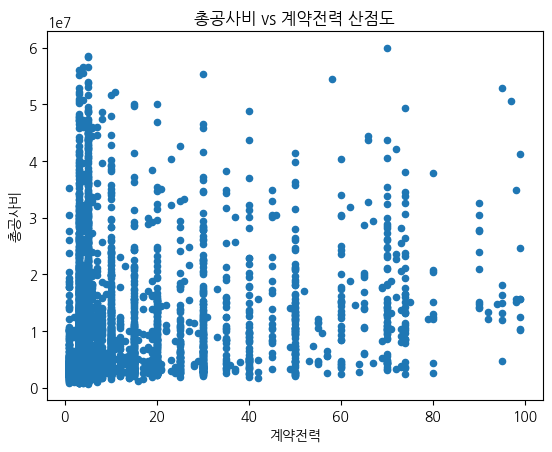

In [22]:
df_data.plot.scatter(x='계약전력', y='총공사비')
plt.xlabel('계약전력')
plt.ylabel('총공사비')
plt.title('총공사비 vs 계약전력 산점도')
plt.show()

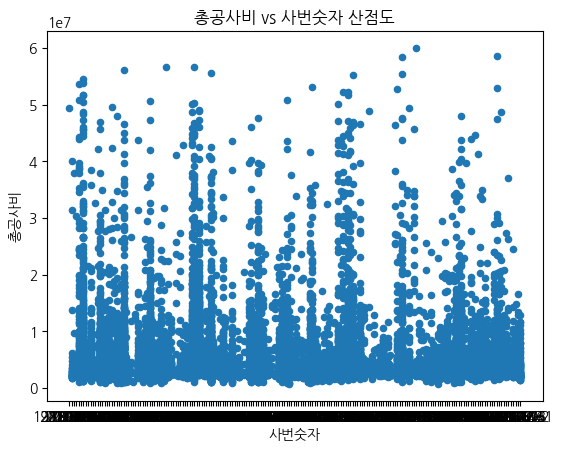

In [23]:
df_data.plot.scatter(x='사번숫자', y='총공사비')
plt.xlabel('사번숫자')
plt.ylabel('총공사비')
plt.title('총공사비 vs 사번숫자 산점도')
plt.show()

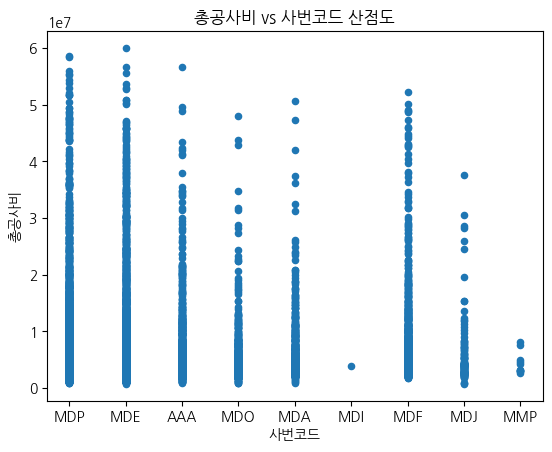

In [24]:
df_data.plot.scatter(x='사번코드', y='총공사비')
plt.xlabel('사번코드')
plt.ylabel('총공사비')
plt.title('총공사비 vs 사번코드 산점도')
plt.show()

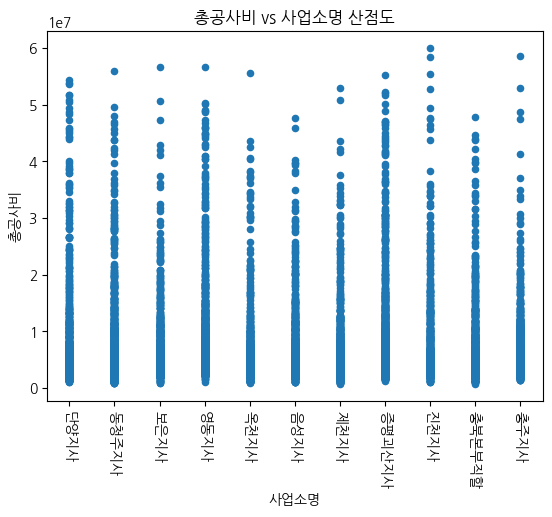

In [25]:
df_data.plot.scatter(x='사업소명', y='총공사비')
plt.xlabel('사업소명')
plt.xticks(rotation=270)
plt.ylabel('총공사비')
plt.title('총공사비 vs 사업소명 산점도')
plt.show()